# Recommendation Systems Assignment

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [69]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

## Support functions and variables

In [2]:
#!unzip ml-100k.zip -d .

In [3]:
MOVIELENS_DIR = "ml-100k"

In [4]:
!ls {MOVIELENS_DIR}

README       u.genre      u.user       u2.test      u4.test      ua.test
allbut.pl    u.info       u1.base      u3.base      u5.base      ub.base
mku.sh       u.item       u1.test      u3.test      u5.test      ub.test
u.data       u.occupation u2.base      u4.base      ua.base


In [5]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [6]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [7]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

('Number of users:', 943)
('Number of items:', 1682)


## Q1

### (a)

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    for(index,userID,itemID,rating,timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [11]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        
        predictionMatrix = np.zeros((num_users, num_items))
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # Extract the items the user already rated
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]
            
            #If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        
        predictionMatrix = np.zeros((num_users, num_items))
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            predictionMatrix[user, item] = itemPopularity[item]
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))


        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [12]:
popularity_recsys = BaseLineRecSys('popularity')

In [13]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [14]:
x = popularity_recsys.getModel()

In [15]:
np.all(x<=1)

True

In [16]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:05, 1521.94it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [18]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [19]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [20]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:04, 1552.60it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [22]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean')) 
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """ 
        manhattan? or super-natural intuition similarity
           
        """ 
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))
     
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
    
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            
        elif self.base == 'item':
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

The cosine similarity works better because euclidean distance is large for vectors of different lengths. If two users have similar likes and tend to watch similar movies but one is tend to give higher ratings than another. Euclidean distance is large for that situation but actually their similarity is high.

### (b)

One of the reasons for using Euclidean and/or Manhattan distance is the relative ease of their implementation. If you want to place less emphasis on outliers, manhattan distance will try to reduce all errors equally since the gradient has constant magnitude.

## Q3

### (a)

In [26]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [27]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [28]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [29]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:05, 1517.37it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [31]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [32]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:03, 1578.29it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


In [184]:
class getRecommender(object):

    def __init__(self, Y, R, num_users, num_items, params=None, n=10, theLambda=10, maxIter=200):
        """
        Args:
            Y - 用户对影片的评分矩阵
            R - 用户j是否对影片i评分的矩阵 (0/1)
            params - 若有初始化参数，可在此传入(Theta, X)
            n - 电影的特征数
            theLambda - 正则化参数
            maxIter - 最大迭代次数
        Returns:
            train - 训练函数
            predict - 预测函数
            getTopRecommends - 获取特定影片的最相似推荐
        """
        self.Y = Y
        self.R = R
        self.params = params
        self.n = n
        self.theLambda = theLambda
        self.maxIter = maxIter
        self.num_users = num_users
        self.num_items = num_items
        self.modified_Y = self.avg_score()[0]
        self.mu = self.avg_score()[1]
        
    def avg_score(self):

        # 标准化影片的评分
        mu = np.zeros((self.num_items, 1), dtype=np.float)
        for i in range(self.num_items):
            totalRates = np.sum(self.Y[i])
            validCount = len(np.nonzero(self.R[i])[0])
            mu[i] = totalRates / validCount
        modified_Y = self.Y - mu
        return modified_Y,mu

    def roll(self, Theta, X):
        """
        对于模型而言，Theta和X都是待学习的参数，需要放在一起直接优化
        Args:
            Theta - 用户偏好矩阵
            X - 电影特征矩阵
        Returns:
            vector - 折叠后的参数
        在numpy中矩阵我们十分常用，但有时候我们会将矩阵转化为数组，
        方法很简单，直接在矩阵名后加 .A 即可。
        """

        #return np.hstack((X.A.T.flatten(), Theta.A.T.flatten()))
        return np.hstack((X.A.T.flatten(), Theta.A.T.flatten()))

    def unroll(self,vector):
        """
        Args:
            vector 参数向量
        Returns:
            Theta - 用户偏好矩阵
            X - 电影特征矩阵
        """
        X = np.mat(vector[:self.num_items * self.n].reshape(self.n, self.num_items).T)
        Theta = np.mat(vector[self.num_items * self.n:].reshape(self.n, self.num_users).T)
        return Theta, X

    def initParams(self):
        """初始化参数

        Returns:
            Theta - 用户偏好矩阵
            X - 电影特征矩阵
        """
        Theta = np.mat(np.random.rand(self.num_users, self.n))
        X = np.mat(np.random.rand(self.num_items, self.n))
        return Theta, X

    def regularize(self,param):
        """对参数进行正则化
        Args:
            param - 参数
        Return:
            regParam - 正规化后的参数
        """
        return self.theLambda * 0.5 * np.sum(np.power(param, 2))

    def J(self, params):
        """代价函数

        Args:
            params - 参数向量
            nu - 用户数
            nm - 电影数
            n - 特征数
        Return:
            J - 预测代价
        """
        # 参数展开
        Theta, X = self.unroll(params)
        # 计算误差
        rows, cols = np.nonzero(self.R)
        # 预测
        h = self.predict(Theta, X)
        self.avg_score()
        diff = h - self.modified_Y
        diff[self.R != 1] = 0
        error = 0.5 * np.sum(np.power(diff, 2))
        
        #  正则化 Theta
        regTheta = self.regularize(Theta)
        #  正规化 x
        regX = self.regularize(X)
        
        return error + regTheta + regX

    def gradient(self, params):
        """计算梯度

        Args:
            params - 参数向量
        Returns:
            grad - 梯度向量
        """
        Theta, X = self.unroll(params)
        
        # 当前梯度初始化成0
        ThetaGrad = np.mat(np.zeros(Theta.shape))
        XGrad = np.mat(np.zeros(X.shape))
        
        error = self.predict(Theta, X) - self.modified_Y
        error[self.R != 1] = 0
        
        # 这里只需要计算梯度
        ThetaGrad = error.T * X + self.theLambda * Theta
        XGrad =  error * Theta + self.theLambda * X
        
        return self.roll(ThetaGrad, XGrad)

    def train(self):
        """训练

        Returns:
            Theta - 用户偏好矩阵
            X - 电影特征矩阵
        """
        # 初始化参数
        if not self.params:
            Theta, X = self.initParams()
        else:
            Theta = self.params['Theta']
            X = self.params['X']
            
        # 最小化目标函数
        res = minimize(self.J, x0=self.roll(Theta, X), jac=self.gradient,
                       method='CG', options={'disp': True, 'maxiter': self.maxIter})
        Theta, X = self.unroll(res.x)
        return Theta, X

    def predict(self, Theta, X):
        """预测
        Args:
            Theta - 用户偏好矩阵
            X - 电影特征矩阵
        Return:
            h 预测
        """
        return X * Theta.T + self.mu

    def getTopRecommends(self, Theta, X, i, count, rated, items):
        """获得推荐

        Args:
            Theta - 用户偏好矩阵
            X - 影片特征矩阵
            i - 用户索引
            count - 目标推荐数量
            rated - 已经评价的影片id
            items - 影片库
        Returns:
            topRecommends - 推荐项目
        """
        predictions = self.predict(Theta, X)[:, i]
        
        # 实用pandas的DataFrame可以将不同类型数据放在一个Frame中，方便排序等操作
        # 相较而言，numpy的多维数组要求内部类型完全一致
        df = pd.DataFrame(data=predictions, columns=['prediction',])
        df['movie'] = items
        df.sort_values(by='prediction', ascending=False,inplace=True)
        # 不推荐已经评过分的影片
        df.drop(rated, inplace=True)
        
        return df[0:count]

    

In [185]:
def getMovie(line):
    return ' '.join(line.split()[1:])
movieList = []
with open('movie_ids.txt') as f:
    for line in f:
        movieList.append(getMovie(line.strip()))


myRatings = np.mat(np.zeros((num_items,1)))

myRatings[0] = 4
myRatings[97] = 2
myRatings[6] = 3
myRatings[11] = 5
myRatings[53] = 4
myRatings[63] = 5
myRatings[65] = 3
myRatings[68] = 5
myRatings[182] = 4
myRatings[225] = 5
myRatings[354] = 5

#u:表示unicode字符串,不是仅仅是针对中文, 可以针对任何的字符串，代表是对字符串进行unicode编码。
#一般英文字符在使用各种编码下, 基本都可以正常解析, 所以一般不带u；但是中文, 必须表明所需编码, 否则一旦编码转换就会出现乱码。 
print u'我的评分:' 
for i in range(num_items):
    if myRatings[i] > 0:
        print u'{:<50} {}'.format( movieList[i], myRatings[i].A[0,0])

我的评分:
Toy Story (1995)                                   4.0
Twelve Monkeys (1995)                              3.0
Usual Suspects, The (1995)                         5.0
Outbreak (1995)                                    4.0
Shawshank Redemption, The (1994)                   5.0
While You Were Sleeping (1995)                     3.0
Forrest Gump (1994)                                5.0
Silence of the Lambs, The (1991)                   2.0
Alien (1979)                                       4.0
Die Hard 2 (1990)                                  5.0
Sphere (1998)                                      5.0


In [186]:
Y = dataPreprocessor(rating_df, num_users, num_items).T
R = Y.astype(bool)

In [188]:
# 将我们的新用户数据加入
Y = np.column_stack((myRatings, Y))
R = np.column_stack((myRatings, R)).astype(bool)

In [190]:
getrecommender = getRecommender(Y, R, num_users+1, num_items, params=None, n=10, theLambda=10, maxIter=200)

In [191]:
Theta, X = getrecommender.train()

         Current function value: 70968.832386
         Iterations: 200
         Function evaluations: 311
         Gradient evaluations: 311


In [192]:
Theta, X

(matrix([[-1.10885202,  0.38094358,  0.129931  , ..., -0.25798043,
          -0.21183504, -0.2061962 ],
         [-1.82382714,  0.01306154,  0.36601534, ..., -0.37173746,
           0.24441562, -0.87837661],
         [-1.30406501,  0.53997951, -0.08879527, ..., -0.38387081,
           0.23903291, -0.4241149 ],
         ...,
         [-1.21119946,  0.36238515,  0.09667597, ..., -0.14064922,
          -0.00585555, -0.27742836],
         [-1.16097862,  0.42901331, -0.00283875, ..., -0.15580987,
          -0.29222477, -0.33623251],
         [-1.05293276,  0.14498352, -0.90040723, ..., -0.67060729,
          -0.60220509, -1.34489184]]),
 matrix([[ 1.39092671, -1.19340605, -0.2918934 , ...,  1.21438619,
          -0.531735  ,  0.38708774],
         [ 1.14232337, -0.33510632, -0.03068044, ...,  0.86386161,
          -0.03846268,  0.48863585],
         [ 0.96992771, -0.42316791,  0.14617324, ...,  0.07198875,
           0.13878048,  0.61932611],
         ...,
         [ 0.1670256 ,  0.00393945

In [194]:
rated = np.nonzero(myRatings)[0].tolist()
# -1 就是我们刚才加入的最新用户
topRecommends = getrecommender.getTopRecommends(Theta, X, -1, 10, rated, movieList)
topRecommends

,prediction,movie
813,4.667510,"Great Day in Harlem, A (1994)"
1598,4.198986,Someone Else's America (1995)
1535,3.853336,Aiqing wansui (1994)
1652,3.819708,Entertaining Angels: The Dorothy Day Story (1996)
1200,3.703305,Marlene Dietrich: Shadow and Light (1996)
1121,3.653813,They Made Me a Criminal (1939)
1499,3.594069,Santa with Muscles (1996)
1491,3.385853,Window to Paris (1994)
1497,3.385801,Farmer & Chase (1995)
1612,3.316223,Tokyo Fist (1995)


### (b)

In [597]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [531]:
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]
cv_RMSE = CrossValidation('RMSE')
results = cv_RMSE.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1565.64it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1628.29it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1705.33it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1700.61it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1698.01it/s]


Processing algorithm user-cosine


20000it [00:11, 1720.05it/s]
20000it [00:11, 1674.60it/s]
20000it [00:11, 1699.18it/s]
20000it [00:11, 1685.97it/s]
20000it [00:11, 1700.00it/s]


In [532]:
print("The average and 95% confidence interval of RMSE results for item-cosine is : [{}, {}]".format(results['item-cosine'][1],results['item-cosine'][2:4]))
print("The average and 95% confidence interval of RMSE results for user-cosine is : [{}, {}]".format(results['user-cosine'][1],results['user-cosine'][2:4]))

The average and 95% confidence interval of RMSE results for item-cosine is : [1.020082900106248, [1.0068242686250732, 1.0333415315874226]]
The average and 95% confidence interval of RMSE results for user-cosine is : [1.0173541216605808, [1.009013080226148, 1.0256951630950135]]


The average number of ratings per user is larger than the average number of ratings per item so for item based collaborative filtering it is more difficult to find similar items than user based which would reduce accuracy of predictions.

## Q4

### (a)

In [39]:
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       item_cosine_recsys, 
                       user_cosine_recsys]
cv_RMSE = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
results_RMSE = cv_RMSE.run(algorithm_instances, num_users, num_items,k=5)
results_patk = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
results_ratk = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1572.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1617.65it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1613.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1653.34it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1592.62it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1627.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1645.47it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1639.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1536.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1633.15it/s]


Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1654.59it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1632.89it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1630.76it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1545.10it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1630.53it/s]


Processing algorithm user-cosine


20000it [00:12, 1630.83it/s]
20000it [00:12, 1628.09it/s]
20000it [00:12, 1588.63it/s]
20000it [00:12, 1650.63it/s]
20000it [00:13, 1538.24it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1491.20it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1594.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1523.44it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:12, 1552.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1251.37it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1258.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1227.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1346.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1397.89it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:19, 1041.41it/s]


Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:16, 1242.15it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:17, 1136.36it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:16, 1215.09it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:15, 1305.52it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:16, 1221.03it/s]


Processing algorithm user-cosine


20000it [00:17, 1137.44it/s]
20000it [00:17, 1175.86it/s]
20000it [00:17, 1126.14it/s]
20000it [00:16, 1202.04it/s]
20000it [00:14, 1341.32it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1383.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1328.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1240.07it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1230.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1310.93it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1374.63it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1378.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1356.17it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1329.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1330.34it/s]


Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:16, 1207.69it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:15, 1263.93it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:15, 1275.23it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:15, 1294.90it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
20000it [00:15, 1328.54it/s]


Processing algorithm user-cosine


20000it [00:16, 1231.61it/s]
20000it [00:16, 1223.11it/s]
20000it [00:15, 1328.62it/s]
20000it [00:14, 1357.07it/s]
20000it [00:14, 1343.78it/s]


In [59]:
for k,v in results_RMSE.items():
    print("The average and CI of RMSE for {} is : [{}, {}]".format(k, results_RMSE[k][1], results_RMSE[k][2:4]))

The average and CI of RMSE for popularity is : [3.1590928909890112, [3.139292746995387, 3.1788930349826354]]
The average and CI of RMSE for useraverage is : [1.0437176561595025, [1.0289303496379316, 1.0585049626810734]]
The average and CI of RMSE for item-cosine is : [1.020082900106248, [1.0068242686250732, 1.0333415315874226]]
The average and CI of RMSE for user-cosine is : [1.0173541216605808, [1.009013080226148, 1.0256951630950135]]


In [61]:
for k,v in results_patk.items():
    print("The average and CI of patk for {} is : [{}, {}]".format(k, results_patk[k][1], results_patk[k][2:4]))

The average and CI of patk for popularity is : [0.5505832449628855, [0.40544114481568705, 0.6957253451100839]]
The average and CI of patk for useraverage is : [0.4736373276776259, [0.3419993013451059, 0.6052753540101459]]
The average and CI of patk for item-cosine is : [0.5322163308589621, [0.3837005215009889, 0.6807321402169354]]
The average and CI of patk for user-cosine is : [0.5558430540827157, [0.40959849499983714, 0.7020876131655943]]


In [62]:
for k,v in results_ratk.items():
    print("The average and CI of ratk for {} is : [{}, {}]".format(k, results_ratk[k][1], results_ratk[k][2:4]))

The average and CI of ratk for popularity is : [0.4840758878843688, [0.3671373629798323, 0.6010144127889052]]
The average and CI of ratk for useraverage is : [0.44132320502242983, [0.32931026359142457, 0.5533361464534351]]
The average and CI of ratk for item-cosine is : [0.4749711148590666, [0.35357317503649865, 0.5963690546816346]]
The average and CI of ratk for user-cosine is : [0.4862687235536437, [0.3694473610987218, 0.6030900860085656]]


### (b)

We can know from the results that popularity cannot be evaluated with RMSE because the popularity is the fraction of people who have rated the movie that liked the movie and it falls in the range of (0,1). It does not make sense to compare two different things.

### (c)

For all of RMSE, P@K, and R@K the best algorithm is user-cosine.First, popularity based recommendations only recommend the most popular items but not recommend items based on the user's likes. User average recommendations are also a very basic method that simply averages the user's ratings for other items. Compared with those baseline algorithms, collaborative filtering is better. The average number of ratings per user is larger than the average number of ratings per item so for item based collaborative filtering it is more difficult to find similar items than user based which would reduce accuracy of predictions.

### (d)

Better RMSE scores on data indicate better generalization of the learned model and often better rankings. Unlike ranking, which focuses more on high-scoring items, RMSE places equal emphasis on high and low ratings. So ranking metrics do not consider the error of low ratings so good ranking metrics do not imply good performance on RMSE 

## Q5

### (a)

In [598]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [599]:
trainUserItemMatrix = dataPreprocessor(rating_df, num_users, num_items)
trainUserItemMatrix = trainUserItemMatrix.T
itemSimilarity = 1 - pairwise_distances(trainUserItemMatrix, metric='cosine')
for i in [6,369,135]:
    print(list(map(lambda x:moviesDF.iloc[x][1],itemSimilarity[i-1].argsort()[-6:-1])))

['Maybe, Maybe Not (Bewegte Mann, Der) (1994)', 'Breaking the Waves (1996)', 'Savage Nights (Nuits fauves, Les) (1992)', 'Chungking Express (1994)', "I Can't Sleep (J'ai pas sommeil) (1994)"]
['Kingpin (1996)', 'Cable Guy, The (1996)', 'Nutty Professor, The (1996)', 'Happy Gilmore (1996)', 'Beverly Hills Ninja (1997)']
['Brazil (1985)', 'Apocalypse Now (1979)', 'Graduate, The (1967)', 'Blade Runner (1982)', 'Raiders of the Lost Ark (1981)']


### (b)

I pick '2001: A Space Odyssey','Black Sheep,''Yao a yao yao dao waipo qiao'. The mechanism of item based collaborative filtering is if two items are rated by alomost the same group of people, the two items are more likely to be in the same class like they are both comedies or animations. For the above three movies, we can find out top 5 similar movies for each of them are more likely to be the same type of movies like mystery or drama.

## Q6 [GRAD ONLY]

### (a)

(array([331., 152.,  75.,  68.,  53.,  52.,  35.,  35.,  29.,  24.,  17.,
         18.,  12.,   9.,   7.,   8.,   5.,   3.,   1.,   1.,   3.,   1.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([ 20.        ,  43.12903226,  66.25806452,  89.38709677,
        112.51612903, 135.64516129, 158.77419355, 181.90322581,
        205.03225806, 228.16129032, 251.29032258, 274.41935484,
        297.5483871 , 320.67741935, 343.80645161, 366.93548387,
        390.06451613, 413.19354839, 436.32258065, 459.4516129 ,
        482.58064516, 505.70967742, 528.83870968, 551.96774194,
        575.09677419, 598.22580645, 621.35483871, 644.48387097,
        667.61290323, 690.74193548, 713.87096774, 737.        ]),
 <a list of 31 Patch objects>)

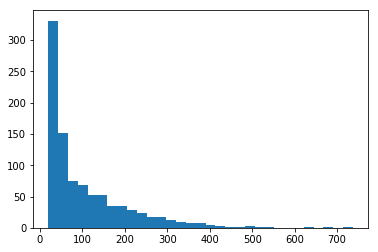

In [624]:
import matplotlib.pyplot as plt
UserItemMatrix = dataPreprocessor(rating_df, num_users, num_items)
data = (UserItemMatrix!=0).sum(1)
plt.hist(data,bins='auto')

In [666]:
above_userID = [i+1 for i,val in enumerate(data.tolist()) if val >= 100]
below_userID = [i+1 for i,val in enumerate(data.tolist()) if val < 100]
above_threshold = rating_df[rating_df['userID'].isin(above_userID)]
below_threshold = rating_df[rating_df['userID'].isin(below_userID)]

In [668]:
class Q6CrossValidation(object):
    def __init__(self, metric, criteria, cdata_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR,criteria)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    

    @staticmethod
    def _getData(data_path,criteria):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            test_set = test_set[test_set['userID'].isin(criteria)]
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [669]:
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]
cv_RMSE_above = Q6CrossValidation('RMSE',above_userID)
cv_RMSE_below = Q6CrossValidation('RMSE',below_userID)
above_results = cv_RMSE_above.run(algorithm_instances, num_users, num_items,k=5)
below_results = cv_RMSE_below.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
15082it [00:08, 1718.81it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
15115it [00:08, 1741.52it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
14748it [00:08, 1760.82it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
14802it [00:08, 1761.25it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
14775it [00:08, 1758.50it/s]


Processing algorithm user-cosine


15082it [00:08, 1830.33it/s]
15115it [00:08, 1813.33it/s]
14748it [00:08, 1800.43it/s]
14802it [00:08, 1767.21it/s]
14775it [00:08, 1791.24it/s]


Processing algorithm item-cosine


f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
4918it [00:02, 1897.19it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
4885it [00:02, 1860.57it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
5252it [00:02, 1842.17it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
5198it [00:02, 1860.12it/s]
f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
5225it [00:02, 1869.73it/s]


Processing algorithm user-cosine


4918it [00:02, 1795.31it/s]
4885it [00:03, 1493.33it/s]
5252it [00:04, 1133.27it/s]
5198it [00:04, 1218.67it/s]
5225it [00:03, 1367.38it/s]


In [670]:
for k,v in above_results.items():
    print("The average and CI of RMSE for {} is : [{}, {}]".format(k, above_results[k][1], above_results[k][2:4]))

The average and CI of RMSE for item-cosine is : [1.0157058792368447, [0.9970328517019386, 1.0343789067717508]]
The average and CI of RMSE for user-cosine is : [1.0099437276866055, [0.9998560554715185, 1.0200313999016926]]


In [671]:
for k,v in below_results.items():
    print("The average and CI of RMSE for {} is : [{}, {}]".format(k, below_results[k][1], below_results[k][2:4]))

The average and CI of RMSE for item-cosine is : [1.0323071802224322, [1.0216936031404484, 1.042920757304416]]
The average and CI of RMSE for user-cosine is : [1.0387105824533651, [1.0296960894624052, 1.047725075444325]]


For both user based and item based filtering, the performance are better with users whose the number of ratings is above the threshold 100. Say that new users who do not have any ratings yet, it is hard to use similarity (collaborative filtering) for them so if users only have rated a few items, the predictions using similarity for them are not that accurate.

# Validation

In [606]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [609]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [610]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [611]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [613]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [614]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [615]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [616]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [617]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [618]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [619]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [620]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [621]:
validateUUSimBasedRecSys()

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [622]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [623]:
validateIISimBasedRecSys()

f:\3.5.2\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
